# Environment

In [29]:
import gc 
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from datetime import datetime
import importlib

import celloracle as co
co.__version__

sys.path.insert(0, "/home/michal.kubacki/Githubs/Re-MEND/code/External_Datasets/GeneSet_Derivation/Herring_celloracle/helpers")


import config
importlib.reload(config)
from config import *
n_cpus = 32

In [30]:
reference = "hg19"

neurons_set = "all_excitatory_all_ages"
# neurons_set = "all_excitatory"

cells_dict = {
    "all_excitatory"            :   ['L5-6_TLE4', 'L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'PN_dev'],
    "all_excitatory_all_ages"   :   ['L5-6_TLE4', 'L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'PN_dev']
}

ages_dict = {
    "all_excitatory"            :   ['1m','3m','6m','10m','1y','2y','4y','ga22','ga24'],
    "all_excitatory_all_ages"   :   ['1m','3m','6m','10m','1y','2y','4y','6y','10y','16y','20y','40y','ga22','ga24']
}

output_dir, input_dir, root_dir, tmp_dir, in_dir_from_scenic = set_custom_folders(reference, neurons_set)

sel_celltypes  = cells_dict[neurons_set]
sel_ages = ages_dict[neurons_set]

root_dir: /group/testa/michal.kubacki/herring
out_dir: /group/testa/michal.kubacki/herring/output_hg19_all_excitatory_all_ages/celloracle
in_dir: /group/testa/michal.kubacki/herring/data
tmp_dir: /group/testa/michal.kubacki/herring/celloracle/tmp


In [31]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Load data

## Load scRNA-seq data

In [32]:
adata = sc.read_h5ad(os.path.join(output_dir, 'subseted_rna_andata.h5ad'))
print(adata)
print(adata.var.shape)
print(adata.obs.shape)

AnnData object with n_obs × n_vars = 14442 × 26609
    obs: 'batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id', 'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust', 'combined-leiden', 'Astro_GFAP_dev-traj', 'Astro_SLC1A2_dev-traj', 'L2_CUX2_LAMP5_dev-traj', 'L3_CUX2_PRSS12_dev-traj', 'L4_RORB_LRRK1_dev-traj', 'L4_RORB_MET_dev-traj', 'L4_RORB_MME_dev-traj', 'L5-6_THEMIS_CNR1_dev-traj', 'L5-6_THEMIS_NTNG2_dev-traj', 'L5-6_TLE4_HTR2C_dev-traj', 'L5-6_TLE4_SCUBE1_dev-traj', 'L5-6_TLE4_SORCS1_dev-traj', 'Micro_dev-traj', 'OPC_dev-traj', 'OPC_MBP_dev-traj', 'Oligo_dev-traj', 'Vas_CLDN5_d

In [33]:
print([f"{celltype}: {len(adata.obs.major_clust[adata.obs.major_clust==celltype])}" for celltype in adata.obs.major_clust.unique()])

['L4_RORB: 3760', 'L5-6_TLE4: 2288', 'L5-6_THEMIS: 2459', 'L2-3_CUX2: 3362', 'PN_dev: 2573']


### Add genes of interests

In [34]:
toadd = ['RARA', 'ESR2', 'THRB']
print(len(toadd))

hvgs = list(adata.var_names[adata.var['highly_variable']])
print(len(hvgs))

3
3000


In [35]:
diff = list(set(toadd).difference(set(hvgs)))
intersec = list(set(toadd).intersection(set(hvgs)))
print(len(diff))
print(len(intersec))

2
1


In [36]:
values_to_remove = list(set(toadd).difference(set(adata.var_names)))
print(len(values_to_remove))

toadd = [item for item in toadd if item not in values_to_remove]

0


In [37]:
hvgs.extend(toadd)
hvgs = pd.Series(hvgs).unique()
print(len(hvgs))


3002


In [38]:
# adata = adata[:, adata.var['highly_variable']]
adata = adata[:, hvgs]
adata

View of AnnData object with n_obs × n_vars = 14442 × 3002
    obs: 'batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id', 'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust', 'combined-leiden', 'Astro_GFAP_dev-traj', 'Astro_SLC1A2_dev-traj', 'L2_CUX2_LAMP5_dev-traj', 'L3_CUX2_PRSS12_dev-traj', 'L4_RORB_LRRK1_dev-traj', 'L4_RORB_MET_dev-traj', 'L4_RORB_MME_dev-traj', 'L5-6_THEMIS_CNR1_dev-traj', 'L5-6_THEMIS_NTNG2_dev-traj', 'L5-6_TLE4_HTR2C_dev-traj', 'L5-6_TLE4_SCUBE1_dev-traj', 'L5-6_TLE4_SORCS1_dev-traj', 'Micro_dev-traj', 'OPC_dev-traj', 'OPC_MBP_dev-traj', 'Oligo_dev-traj', 'Vas_

In [39]:
gc.collect()

37

# CellOracle

## Init CellOracle object

In [40]:
oracle = co.Oracle()

In [41]:
oracle.import_anndata_as_raw_count(adata,
                                   cluster_column_name="major_clust",
                                   embedding_name="X_umap")

In [42]:
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.18.0
    n_cells: 14442
    n_genes: 3002
    cluster_name: major_clust
    dimensional_reduction_name: X_umap
    n_target_genes_in_TFdict: 0 genes
    n_regulatory_in_TFdict: 0 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 0 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 0 genes
    k_for_knn_imputation: NA
Status
    Gene expression matrix: Ready
    BaseGRN: Not imported
    PCA calculation: Not finished
    Knn imputation: Not finished
    GRN calculation for simulation: Not finished

In [43]:
# base_GRN = co.data.load_human_promoter_base_GRN() 
# base_GRN = pd.read_parquet("./data/2023_11_tfi.celloracle.parquet", engine='pyarrow')
# base_GRN = pd.read_parquet(os.path.join(output_dir, "Herring_motif_scan.celloracle.parquet"), engine='pyarrow')

In [44]:
cell_type = sel_celltypes[0]

file_path = os.path.join(output_dir, f"{cell_type}.celloracle.parquet")
base_GRN = pd.read_parquet(file_path, engine='pyarrow')


base_GRN.head()

,peak_id,gene_short_name,AC023509.3,AC138696.1,AHR,AIRE,ALX1,ALX3,ALX4,ANHX,...,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN30,ZSCAN31,ZSCAN4,ZSCAN5,ZSCAN5C,ZSCAN9,ZZZ3
0,chr10_100206318_100206818,HPS1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr10_101088845_101089345,CNNM1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,chr10_101190283_101190783,GOT1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr10_101380124_101380624,SLC25A28,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,chr10_101418847_101419347,ENTPD7,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [46]:
External_data = pd.read_csv(os.path.join(input_dir, "2023_11_CellOracleProof.tsv"),delimiter="\t")
External_data

,TF,Target_genes
0,ADSL,"ATOH1,FBXO32,SSTR2,KALRN,AP003049.2,S100A11,MY..."
1,AKAP8,"AC073050.1,AC092069.1,AC092957.1,ACAT2,ADCY8,A..."
2,ANKLE2,"ADGRL4,LINC00682,PHOX2B,TMEM163,LRRC75A,LRP2,DLK1"
3,BBIP1,"ADGRL4,AP003049.2,CDH20,DLL3,SFRP1,UBE2C,TPX2,..."
4,DCHS1,"AC096711.2,FAM181B,AC092069.1,LMO2,AC092957.1,..."
5,HTT,"AC068308.1,AC090015.1,AC092957.1,AC092958.1,AC..."
6,KIF15,"LRRC75A,AC092069.1,PDZRN4,ADGRL4,RHOJ,NFIA,CBL..."
7,KIF18A,"ANGPT1,ATAD5,ATP5F1E,BMP5,BTBD17,CBLN1,CCDC102..."
8,KNL1,"CHSY3,SGCZ,DPYD,ADGRL4,LINC01965,FABP7,NKAIN3,..."
9,MTUS1,"ACAT2,ACTA2,ADGRL2,ADM,AIF1,AL357507.1,ANGPT1,..."


In [47]:
TF_to_TG_dictionary = {}

for TF, TGs in zip(External_data.TF, External_data.Target_genes):
    # convert target gene to list
    TG_list = TGs.replace(" ", "").split(",")
    # store target gene list in a dictionary
    TF_to_TG_dictionary[TF] = TG_list

# We invert the dictionary above using a utility function in celloracle.
TG_to_TF_dictionary = co.utility.inverse_dictionary(TF_to_TG_dictionary)

oracle.addTFinfo_dictionary(TG_to_TF_dictionary)

  0%|          | 0/571 [00:00<?, ?it/s]

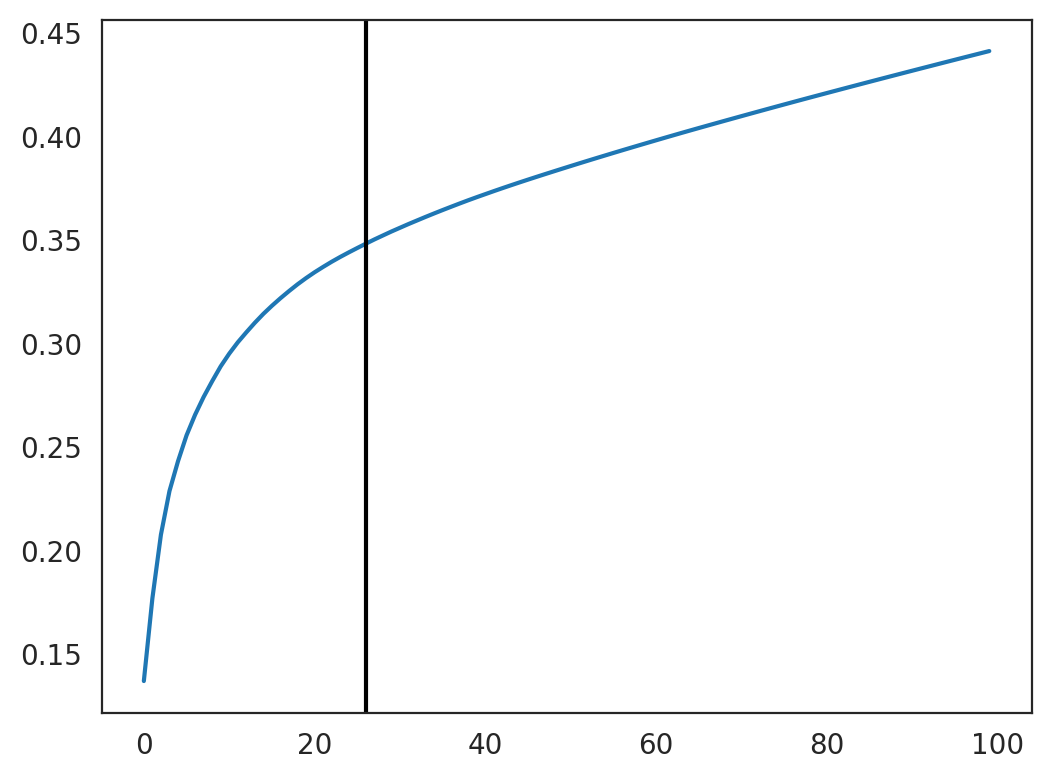

26


In [48]:
oracle.perform_PCA()

plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [49]:
gc.collect()

3044

In [50]:
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=n_cpus)

Auto-selected k is :361


In [51]:
sc.pp.neighbors(oracle.adata)

In [52]:
sc.tl.umap(oracle.adata) #, min_dist=0.3

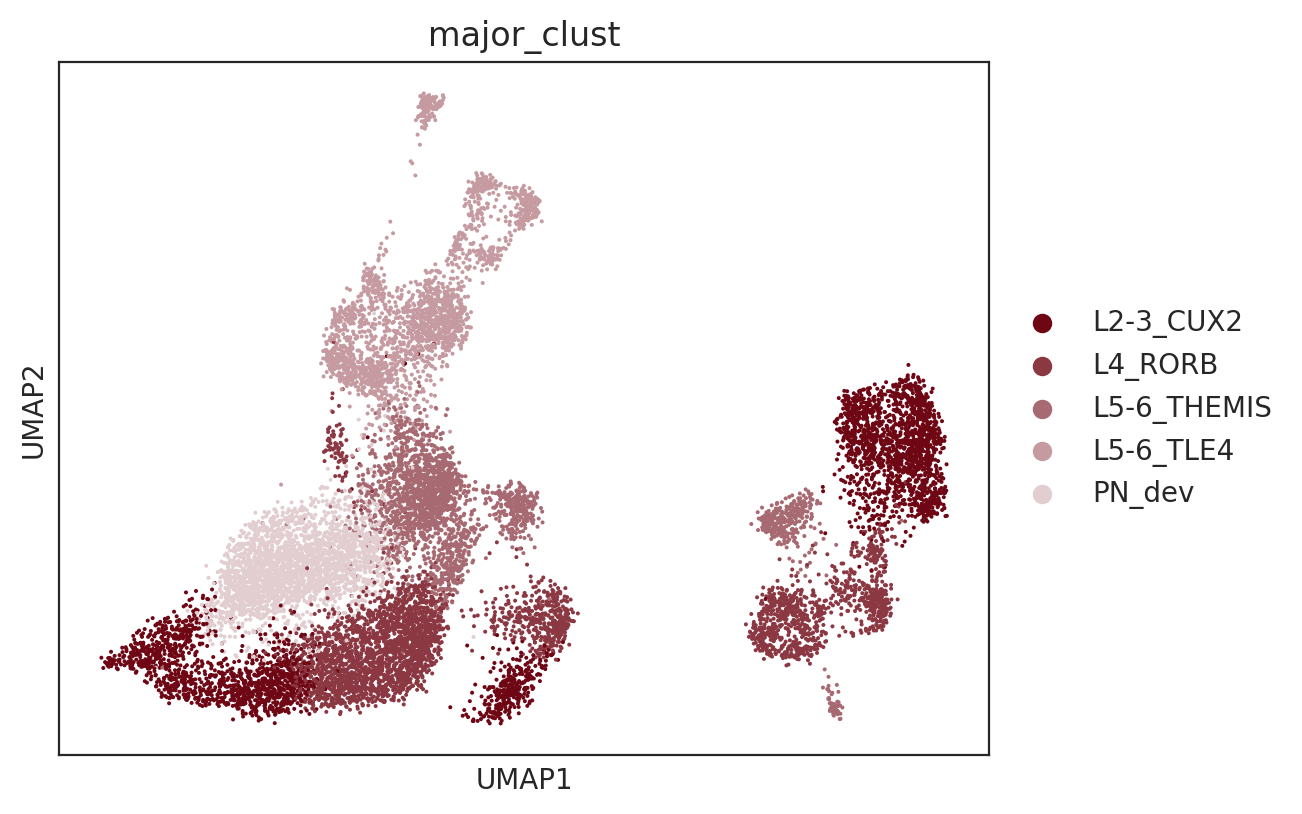

In [53]:
sc.pl.umap(oracle.adata, color = "major_clust", layer="imputed_count")

In [54]:
# current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
# file_name = os.path.join(output_dir, f"oracle_1.celloracle.oracle")
# oracle.to_hdf5(file_name)

In [55]:
gc.collect()

26360

## Inferring GRN

In [56]:
links = oracle.get_links(cluster_name_for_GRN_unit="major_clust", alpha=10,
                         verbose_level=10, n_jobs=n_cpus)

  0%|          | 0/5 [00:00<?, ?it/s]

Inferring GRN for L2-3_CUX2...


  0%|          | 0/973 [00:00<?, ?it/s]

Inferring GRN for L4_RORB...


  0%|          | 0/973 [00:00<?, ?it/s]

Inferring GRN for L5-6_THEMIS...


  0%|          | 0/973 [00:00<?, ?it/s]

Inferring GRN for L5-6_TLE4...


  0%|          | 0/973 [00:00<?, ?it/s]

Inferring GRN for PN_dev...


  0%|          | 0/973 [00:00<?, ?it/s]

In [57]:
links.links_dict.keys()

dict_keys(['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4', 'PN_dev'])

In [83]:
# links.filter_links()
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)


In [84]:
links.get_network_score()

In [85]:
links.merged_score.head()

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
ERG,42,0.073427,0,0.000000,42,0.073427,0.0,0.150450,L2-3_CUX2
BRINP3,7,0.012238,7,0.012238,0,0.000000,0.0,0.044195,L2-3_CUX2
EGR1,198,0.346154,1,0.001748,197,0.344406,449.0,1.000000,L2-3_CUX2
DGKB,2,0.003497,2,0.003497,0,0.000000,0.0,0.236309,L2-3_CUX2
HES1,38,0.066434,0,0.000000,38,0.066434,0.0,0.104863,L2-3_CUX2


In [86]:
# current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
# file_name = os.path.join(output_dir, f"links_1.celloracle.links")
# links.to_hdf5(file_path=file_name)

In [87]:
# file_name = os.path.join(output_dir, "Herring_links_20240404_160414.celloracle.links")
# links = co.load_hdf5(file_name)

In [88]:
plt.rcParams["figure.figsize"] = [9, 4.5]

L2-3_CUX2


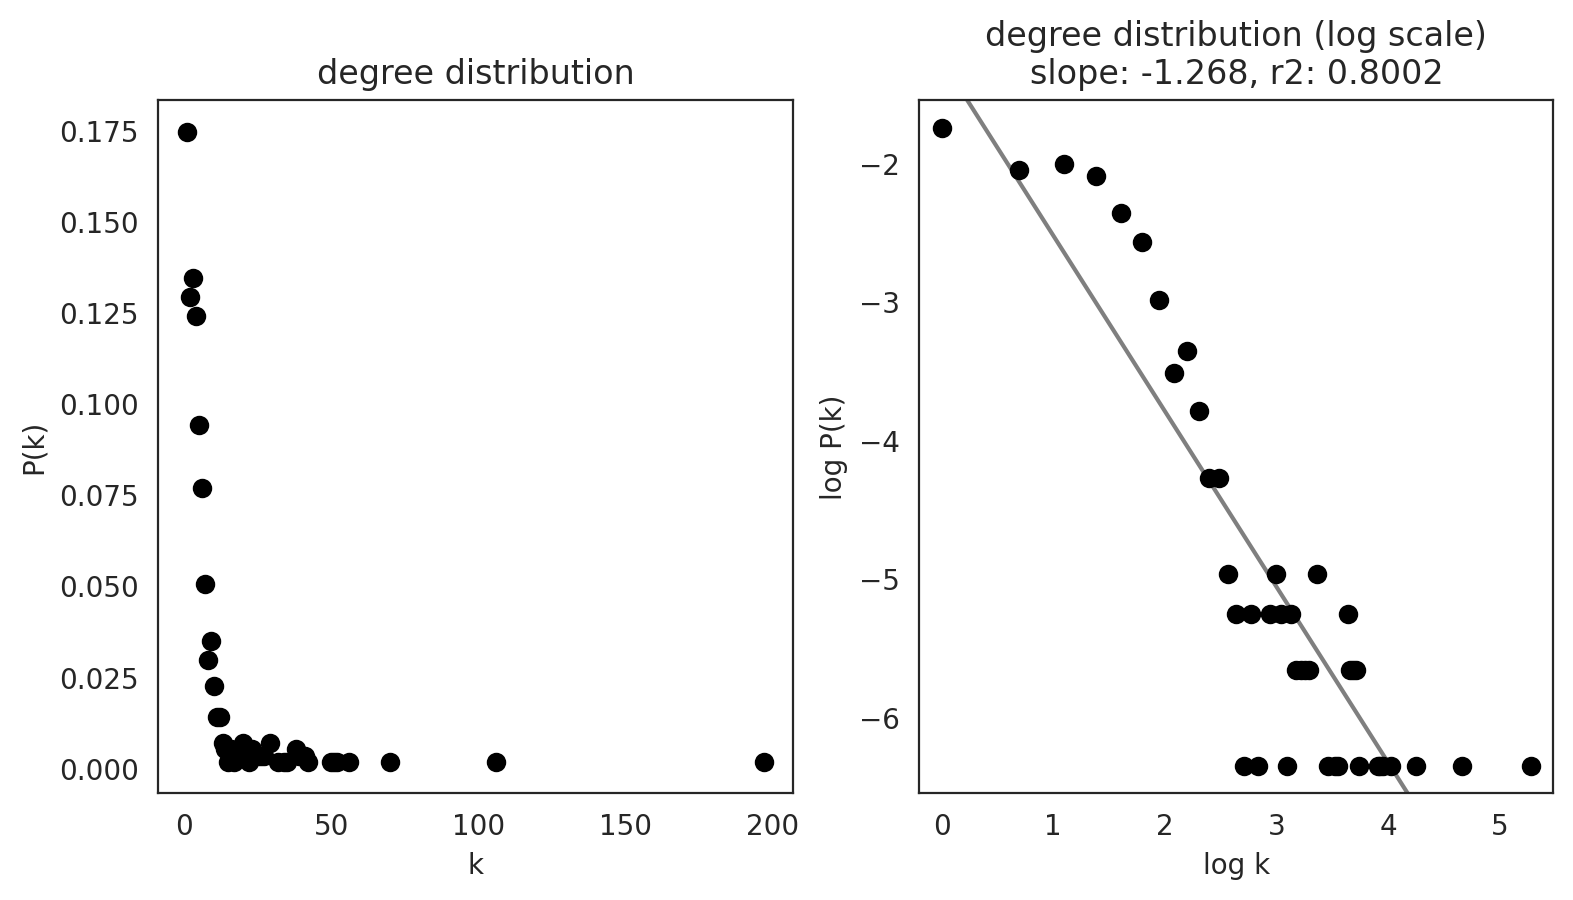

L4_RORB


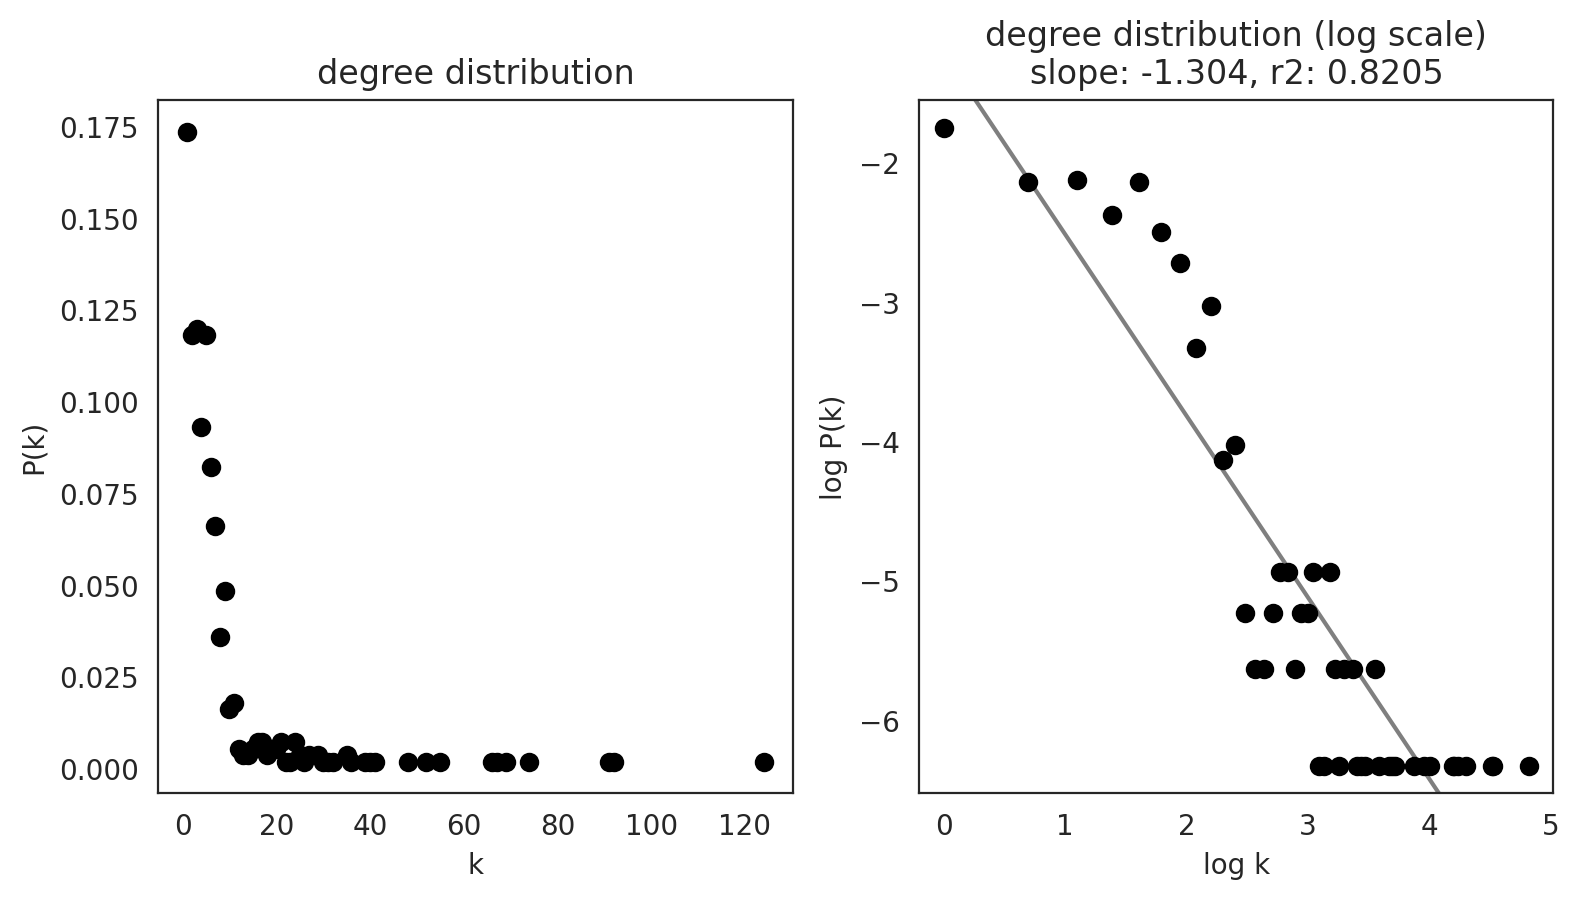

L5-6_THEMIS


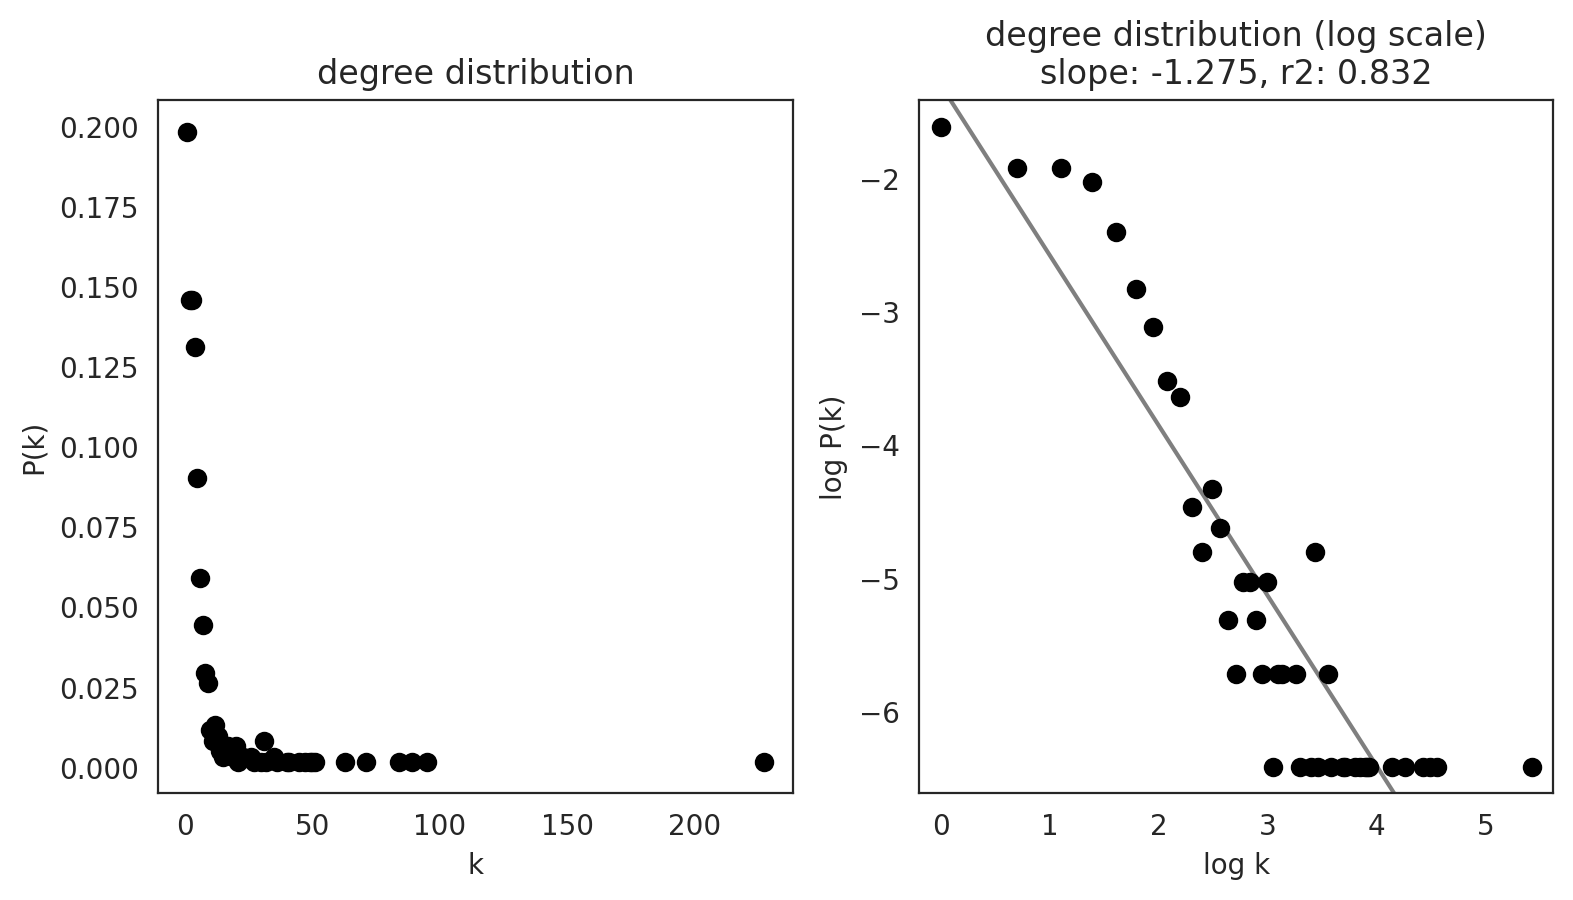

L5-6_TLE4


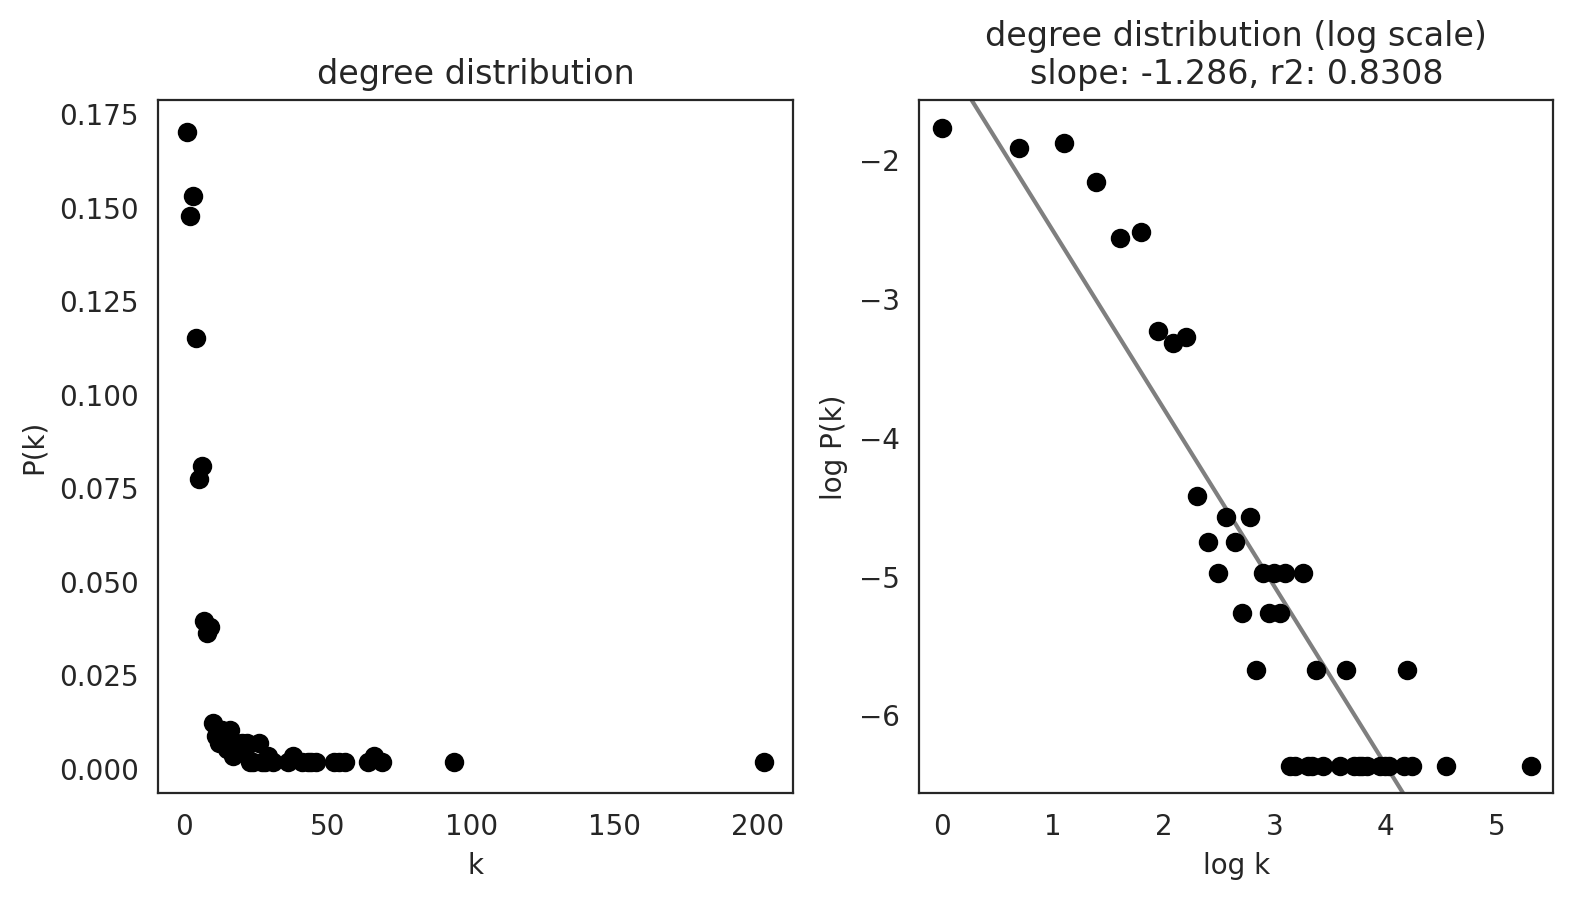

PN_dev


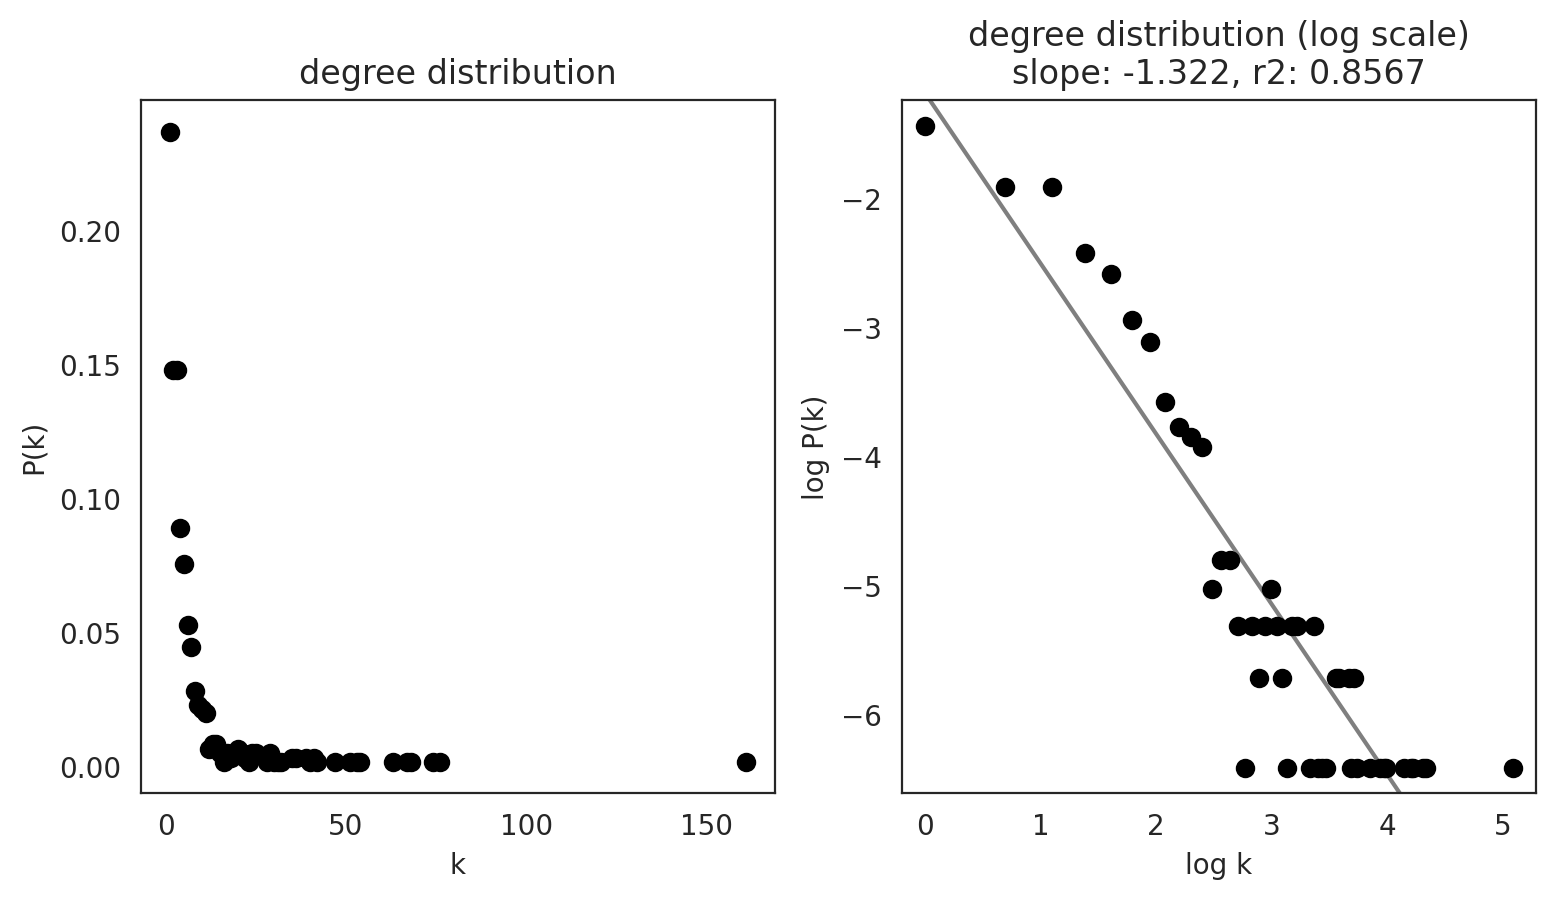

In [89]:
links.plot_degree_distributions(plot_model=True)

In [65]:
plt.rcParams["figure.figsize"] = [6, 4.5]

In [66]:
links.cluster

['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4', 'PN_dev']

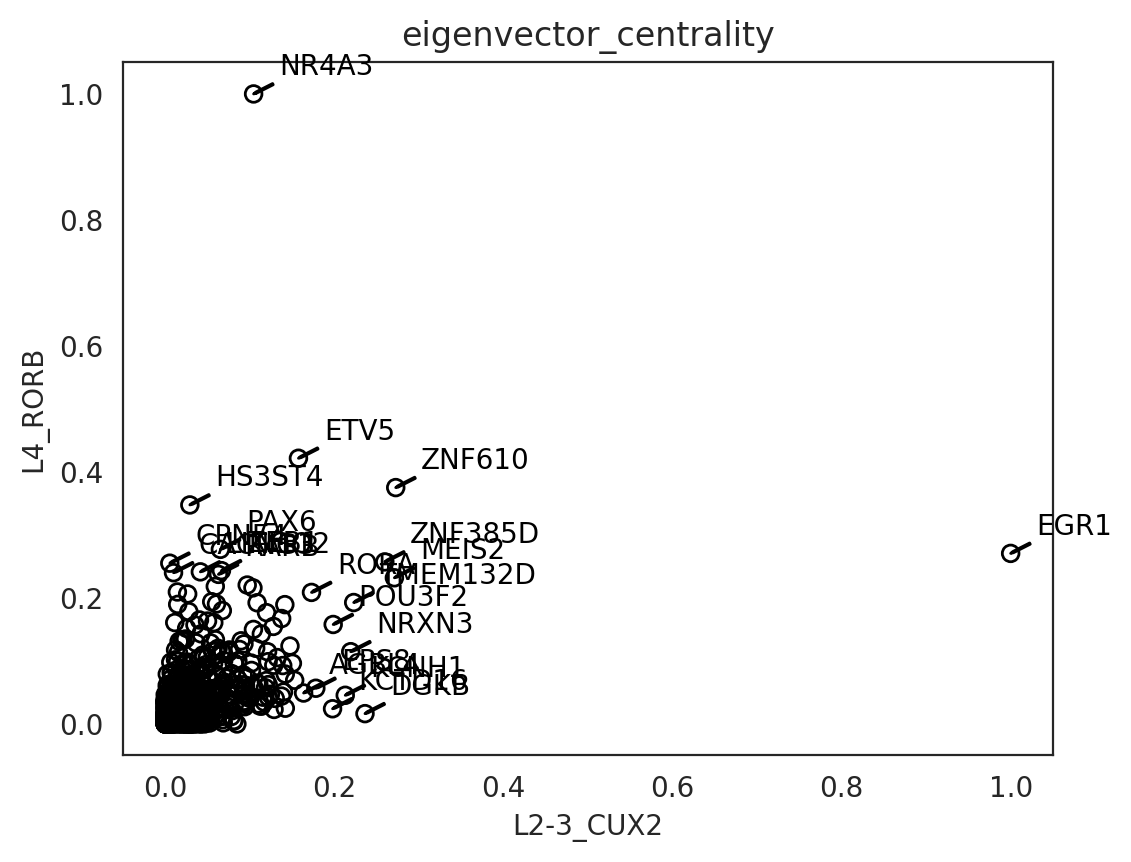

In [67]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="L2-3_CUX2", cluster2="L4_RORB",
                               percentile=98)

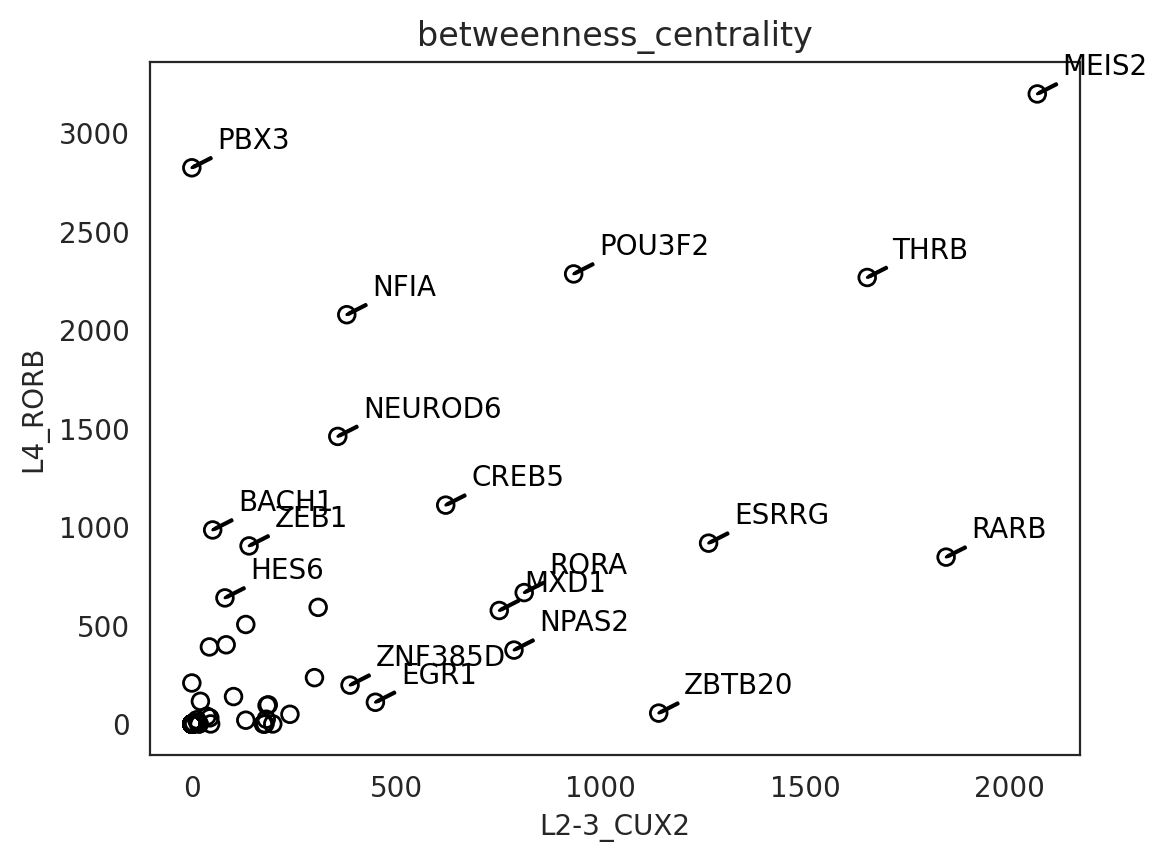

In [68]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="L2-3_CUX2", cluster2="L4_RORB",
                               percentile=98)
